# Predicting Titanic survivors with Apache Spark

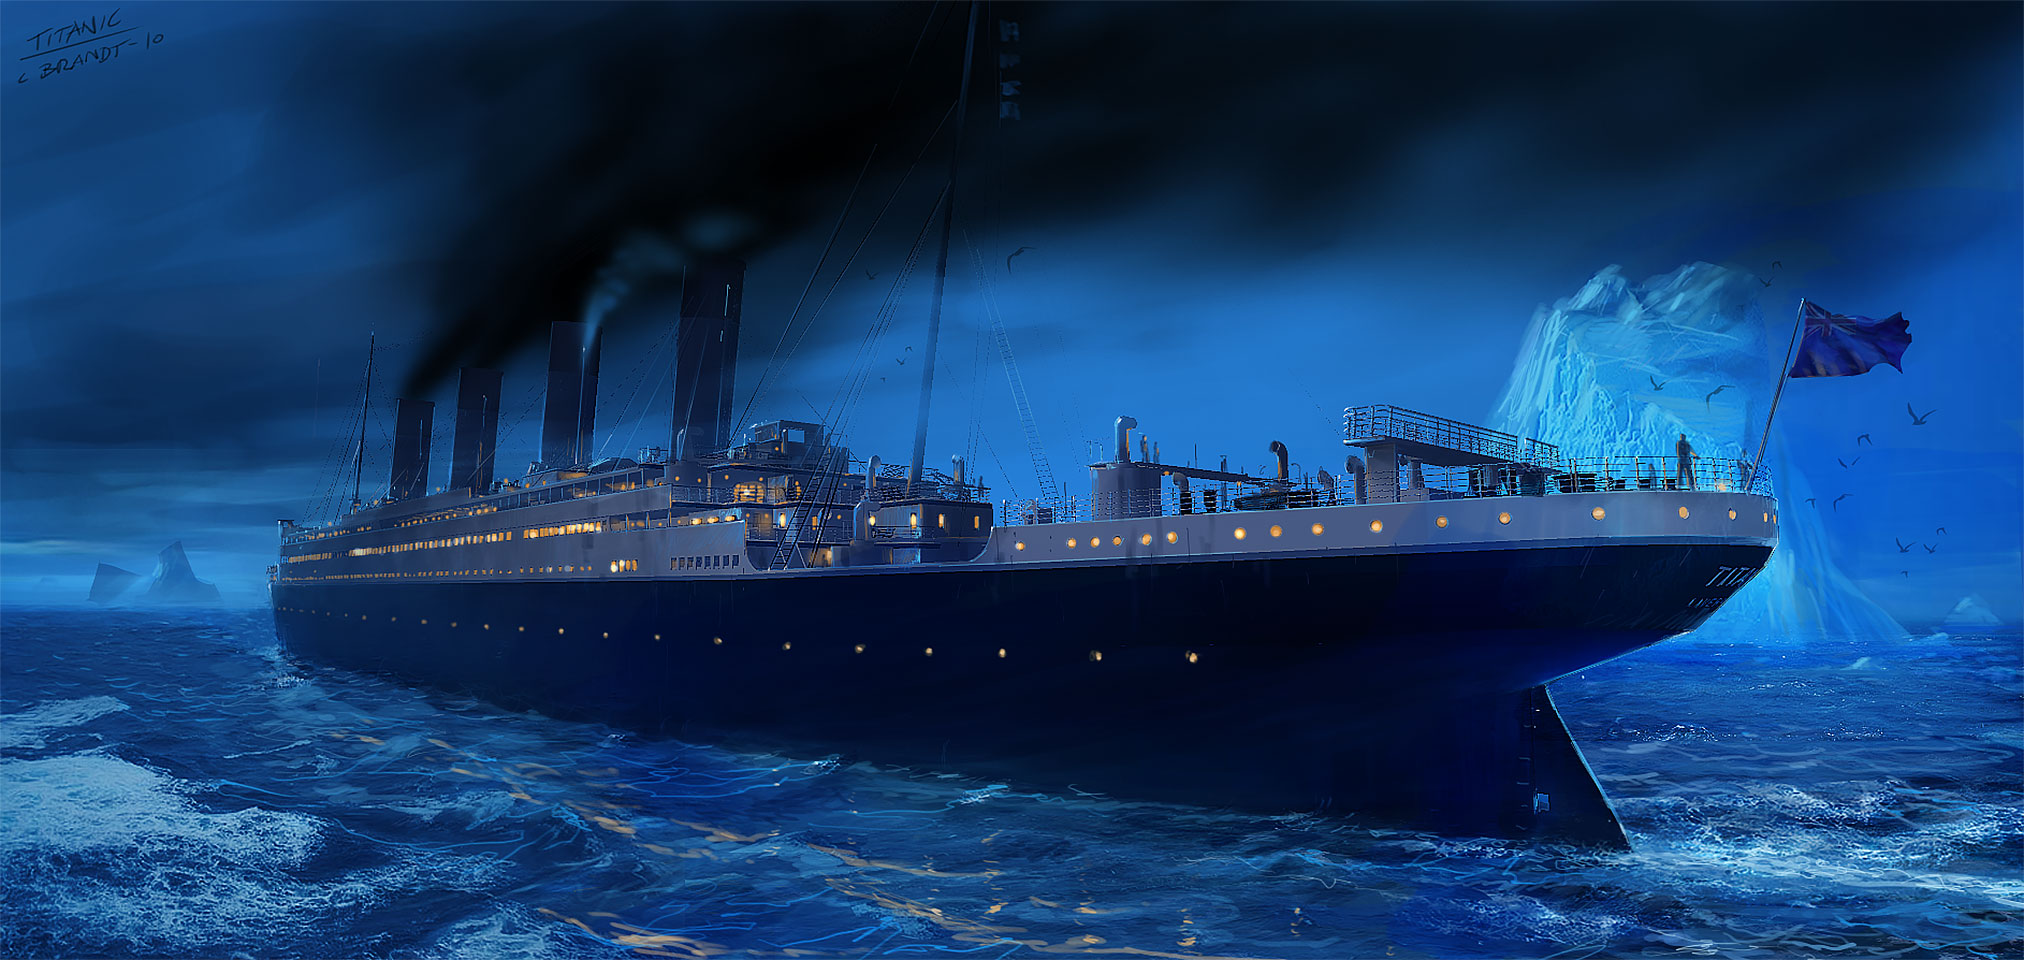



Гибель Титаника является одним из самых печально известных кораблекрушений в истории. 15 апреля 1912 года во время своего первого плавания, Титаник затонул после столкновения с айсбергом, при этом погибло 1502 из 2224 пассажиров и членов экипажа.

Некоторые группы людей имели больше шансов выжить, по сравнению с другими. Например, женщины, дети, пассажиры высшего класса.

В этой работе применяются методы машинного обучения для проедсказания того, какие пассажиры могли выжить в этой трагедии.

# Задача

**Задача** — **знакомство с Apache Spark**.

**Доп. задача** - **построить модель, которая лучшим образом сможет предсказать, остался ли произвольный пассажир в живых или нет**.

## Импорты:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pyspark
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, desc, asc

from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler, Imputer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import (
    NaiveBayes,
    DecisionTreeClassifier,
    RandomForestClassifier,
    LogisticRegression,
    MultilayerPerceptronClassifier,
)

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

RND = 21

## 1. Создание сессии

In [2]:
spark = (
    SparkSession.builder
    .appName('Apache Spark Beginner')
    .config("spark.executor.memory", "1G")
    .config("spark.executor.cores","4")
    .getOrCreate()
)
spark.sparkContext.setLogLevel('INFO')

spark

## 2. Загрузка данных

In [3]:
train_df = spark.read.csv('./data/train.csv', header=True, inferSchema=True)
test_df = spark.read.csv('./data/test.csv', header=True, inferSchema=True)
gender_sub_df = spark.read.csv('./data/gender_submission.csv', header=True, inferSchema=True)

In [4]:
gender_sub_df.show(5)

+-----------+--------+
|PassengerId|Survived|
+-----------+--------+
|        892|       0|
|        893|       1|
|        894|       0|
|        895|       0|
|        896|       1|
+-----------+--------+
only showing top 5 rows



In [5]:
train_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

Рассмотрим внимательнее, что содержится в данном датасете. Ниже представлена краткая информация о каждом из стобцов датасета:

|Column name|Content                                          |Value                                         |
|-----------|-------------------------------------------------|----------------------------------------------|
|PasengerId |никальный индекс                                 |                                              |
|Survived   |Признак, показывающий был ли спасен данный пассажир или нет|0 = No, 1 = Yes                     |
|Pclass     |Класс билета                                     |1 = 1st, 2 = 2nd, 3 = 3rd                     |
|Name       |Имя пассажира                                    |"Mr" для мужчин. "Mrs" для женщин. "Miss" для девушек "Master" для юношей.|
|Sex        |Пол пассажира                                    |                                              |
|Age        |Возраст пассажира                                |                                              |
|SibSp      |Количество братьев/сестер или супругов           |                                              |
|Parch      |Количество родителей и детей                     |                                              |
|Ticket     |Номер билета                                     |                                              |
|Fare       |Сумма, которую заплатил пассажир за путешествие  |                                              |
|Cabin      |Номер каюты                                      |                                              |
|Embarked   |Порт отправления                                 |C = Cherbourg, Q = Queenstown, S = Southampton|

Помимо примеров данных, нам нужно понимать размерности, т.е. сколько всего строк/столбцов присутсвует в загруженных файлах.

Если бы мы использовали `DataFrame` из пандаса, то смогли бы посмотреть размернось при помощи `.shape` или `np.shape()`, работая со спарком мы можем посмотреть размерность строк/столбцов по отдельности `.count()/len()`

Напишем небольшую "ф-цию заменитель" `.shape`

In [6]:
def spark_shape(self):
    # ф-ция заменитель .shape`
    return (self.count(), len(self.columns))

pyspark.sql.dataframe.DataFrame.shape = spark_shape

In [7]:
train_df.shape()

(891, 12)

Мы видим, что всего в обучающем наборе содержатся $891$ строка/запись и $12$ столбцов.

`.describe()` отобразит различные величины, такие как количесmво, среднее, среднеквадратичное отклонение и т.д. для численных типов данных.

In [8]:
train_df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

Если `.show()` искажает вывод таблицы, то можем попробовать отобразить информацию вертикально.

In [9]:
train_df.describe().show(vertical=True)

-RECORD 0---------------------------
 summary     | count                
 PassengerId | 891                  
 Survived    | 891                  
 Pclass      | 891                  
 Name        | 891                  
 Sex         | 891                  
 Age         | 714                  
 SibSp       | 891                  
 Parch       | 891                  
 Ticket      | 891                  
 Fare        | 891                  
 Cabin       | 204                  
 Embarked    | 889                  
-RECORD 1---------------------------
 summary     | mean                 
 PassengerId | 446.0                
 Survived    | 0.3838383838383838   
 Pclass      | 2.308641975308642    
 Name        | null                 
 Sex         | null                 
 Age         | 29.69911764705882    
 SibSp       | 0.5230078563411896   
 Parch       | 0.38159371492704824  
 Ticket      | 260318.54916792738   
 Fare        | 32.2042079685746     
 Cabin       | null                 
 

Теперь отобразим статистики (descriptive statistics) объектного типа. Это нужно для нечисловых данных, когда нельзя просто посчитать максимумы/среднее/и пр. для данных. Мы можем отнести такие данные к категориальному виду.

In [10]:
train_df.toPandas().describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


* Cущесвуют дубликаты номеров билетов `Ticket`, самым повторяющимся стал `347082`
* Наибольшее число людей занимающих $1$ каюту = $4$
* $644$ человека отбыли из порта `S`.
* Среди $891$ человека, $577$ были мужчины (`Male`) и оставшием женщины (`Female`).

In [11]:
train_df.printSchema()
print(f'Data size: {train_df.shape()[0]} row(s), {train_df.shape()[1]} column(s)')

train_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_df.columns]).show()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

Data size: 891 row(s), 12 column(s)
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



* `Age` - 177 (~20%) записей с пропущенным возрастом;
* `Cabin` - 687 (~77%) записей с пропущенным значение каюты;
* `Embarked` - 2 (~0,2%) записи с пропущенными значениями.

### 2.1 Посмотрим на тестовый датасет

In [12]:
def info_spark_df(df):
    # first look
    df.printSchema()
    print(f'Data size: {df.shape()[0]} row(s), {df.shape()[1]} column(s)')
    df.select([count(when(isnan(c) | pyspark.sql.functions.col(c).isNull(), c)).alias(c) for c in df.columns]).show()
    df.describe().show(vertical=True)

In [13]:
info_spark_df(test_df)

root
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

Data size: 418 row(s), 11 column(s)
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|     0|   0|  0| 86|    0|    0|     0|   1|  327|       0|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+

-RECORD 0---------------------------
 summary     | count                
 PassengerId | 418                  
 Pclass      | 418                  
 Name        | 418          

* `Age` - присутствуют пропуски(из 418 записей, только у 322 есть значения);
* `Fare` - есть 1 пропущенное значение;
* `Cabin` - только у 91 записи есть значения.

## 3 EDA

Для визуализации будем использовать пандосовский фрейм

In [14]:
df = train_df.toPandas()

In [15]:
def bar_plt(categories, counts, title):
    plt.figure(figsize=(10,10))
    plt.bar(categories, counts, width=0.65)
    plt.title(title)
    plt.show()

### 3.1 Влияние класса билета на выживаемость

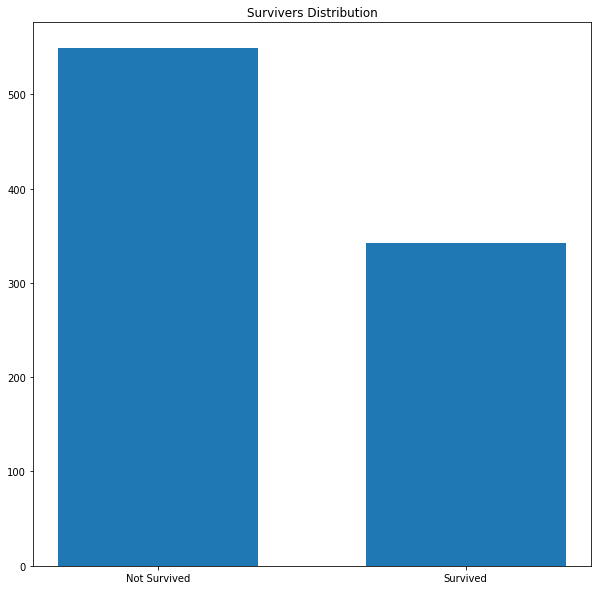

In [16]:
bar_plt(
    ["Not Survived", "Survived"],
    df['Survived'].value_counts().values,
    'Survivers Distribution',
)

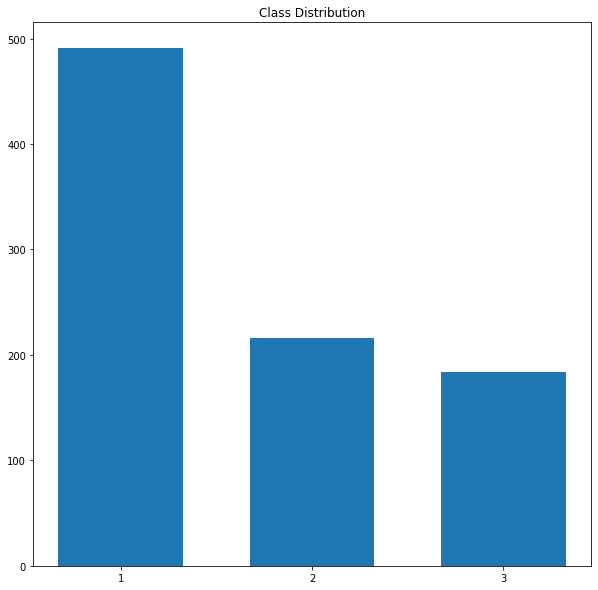

In [17]:
bar_plt(
    ["1", "2", "3"],
    df['Pclass'].value_counts().values,
    'Class Distribution',
)

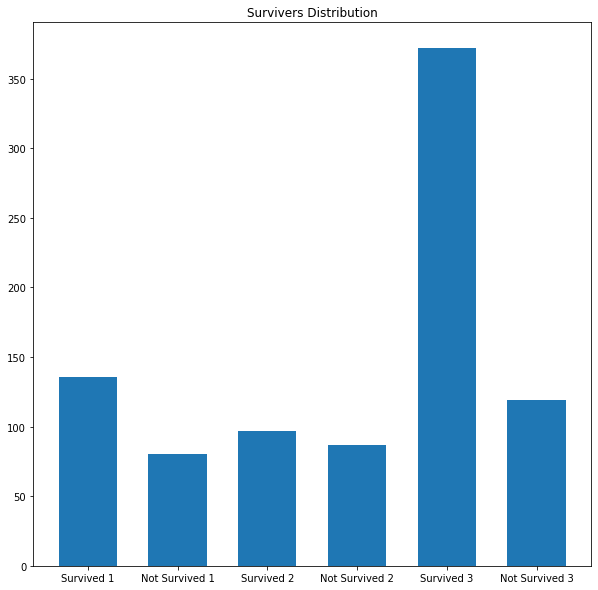

In [18]:
spis = []
for cl in [1, 2, 3]:
    for surv in [1, 0]:
        if surv == 1:
            spis.append('Survived ' + str(cl))
        else:
            spis.append('Not Survived ' + str(cl))

bar_plt(
    spis,
    df.groupby('Pclass').Survived.value_counts(),
    'Survivers Distribution'
)

***Исходя из полученных результатов:***
* Пассажиры более высокого класса имели наибольшие шансы на спасение.

### 3.3 Влияние пола на выживаемость

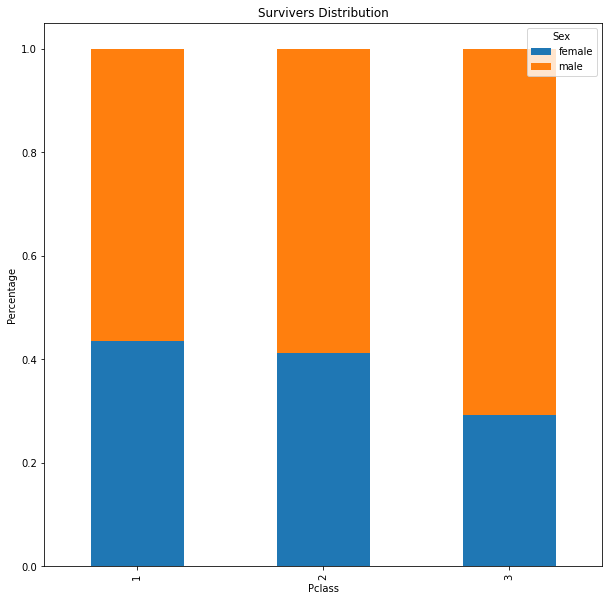

In [19]:
tab = pd.crosstab(df['Pclass'], df['Sex'])

tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(10,10))
plt.xlabel('Pclass')
plt.ylabel('Percentage')
plt.title('Survivers Distribution')
plt.show()

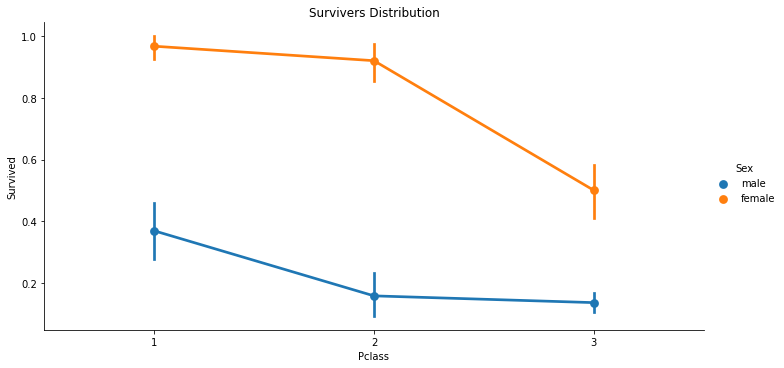

In [20]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', aspect=2, data=df, kind='point', figsize=(10,15))
plt.title('Survivers Distribution')
plt.show()

***Исходя из полученных результатов:***
* Женщины из 1 и 2 классов имели практически **100%** на спасение;
* Мужчины из 2 и 3 классов имели **~16%** на спасение;
* Очевидно, что независимо от `Pclass`, женщинам давали приоритет во время спасения.

### 3.4 Распределение пассажиров по классам, исходя из места их посадки

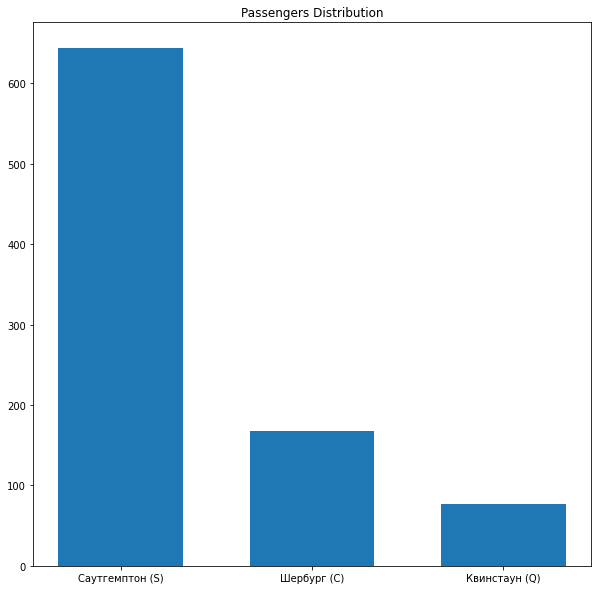

In [21]:
bar_plt(
    ["Саутгемптон (S)", "Шербург (C)", "Квинстаун (Q)"],
    df['Embarked'].value_counts(),
    'Passengers Distribution',
)

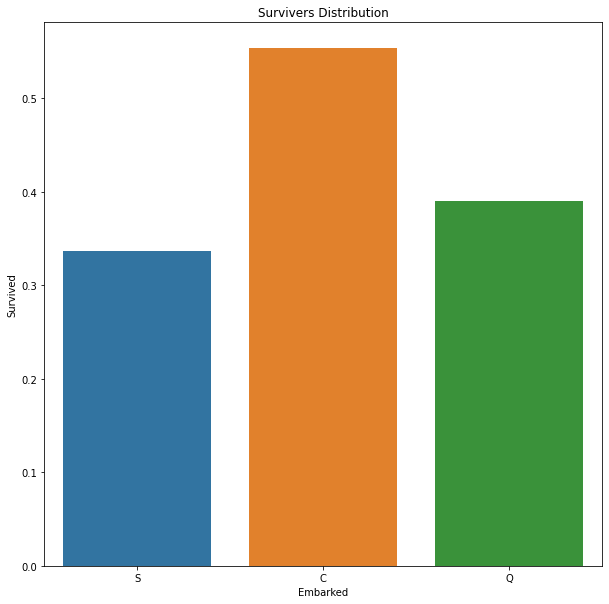

In [22]:
plt.figure(figsize=(10,10))
sns.barplot(x='Embarked', y='Survived', data=df, ci=None)
plt.title('Survivers Distribution')
plt.show()

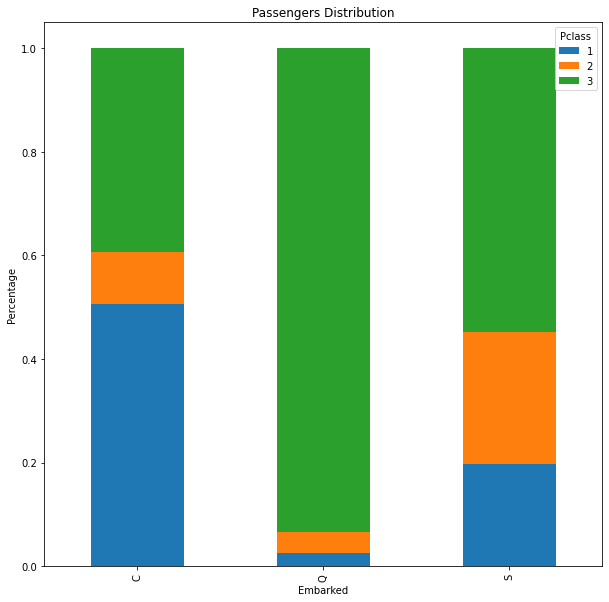

In [23]:
tab = pd.crosstab(df['Embarked'], df['Pclass'])

tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(10,10))
plt.xlabel('Embarked')
plt.ylabel('Percentage')
plt.title('Passengers Distribution')
plt.show()

***Исходя из полученных результатов:***
* `C`-Шербург (второй порт посадки): 
    - Наибольшее кол-во пассажиров были из 1-го класса;
    - Наибольшее кол-во выживших отправилось из данного порта.
* `S`-Саутгемптон (первый порт):
    - Наибольшее кол-во пассажиров были из 2-го класса; 
    - Из этого порта отправилось наименьшее кол-во выживших;
    - Место посадки наибольшего кол-ва пассажиров.
* `Q`-Квинстаун (последний порт на пути следования):
    - наибольшее кол-во пассажиров были из 3-го класса.

### 3.5 Влияние возраста на выживаемость

In [24]:
print(f'Oldest Passenger was of: {df["Age"].max()} Years')
print(f'Youngest Passenger was of: {df["Age"].min()} Years')
print(f'Average Age on the ship: {df["Age"].mean()} Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


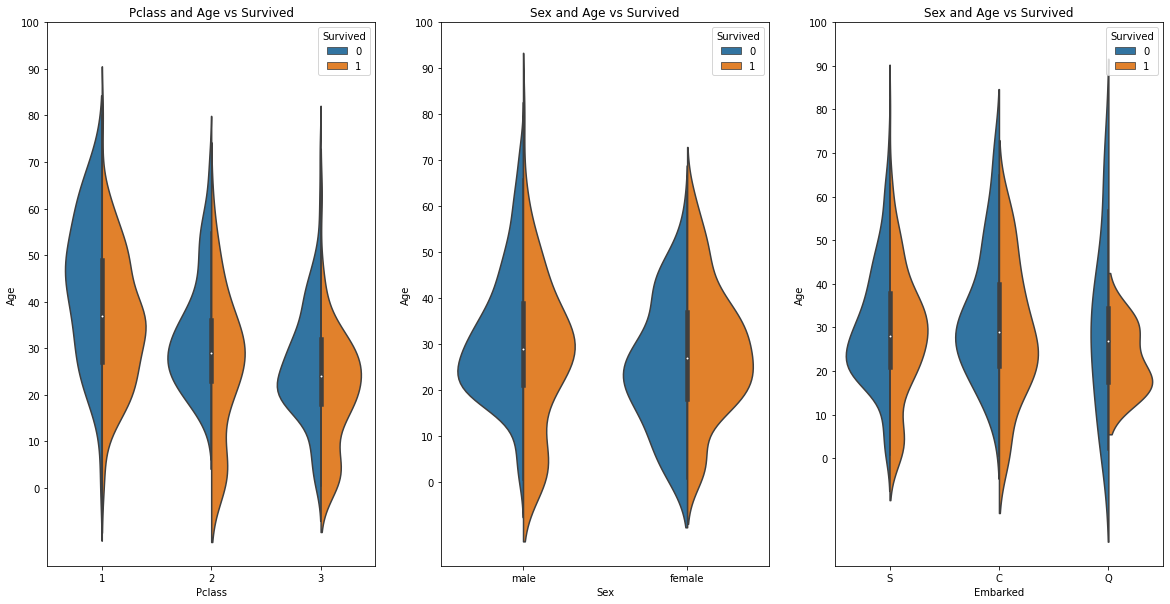

In [25]:
#subplots
fig, ax=plt.subplots(1,3,figsize=(20,10))

sns.violinplot("Pclass", "Age", hue="Survived", data=df, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))

sns.violinplot("Sex", "Age", hue="Survived", data=df, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))

sns.violinplot("Embarked", "Age", hue="Survived", data=df, split=True, ax=ax[2])
ax[2].set_title('Sex and Age vs Survived')
ax[2].set_yticks(range(0,110,10))
plt.show()

***Исходя из полученных результатов:***
* Самой старшей категорией стали пассажиры 1-го класса;
* Более молодые люди из первого класса спасались по сравнению к более пожилым.
* Почти все дети(0-10) из 2-го класса спаслись;
* Большинству детей 3-го класса удалось спастись;
* Большинство детей мужского пола(0-14) спаслись;
* Девушки и жещины имели больший шанс на спасение.

## 4. Preprocessing

In [26]:
p_df_train, p_df_test = train_df.toPandas(), test_df.toPandas() # Pandas_DataFrame
train_test_data = [p_df_train, p_df_test]

for dataset in train_test_data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.')

Если посмотреть на то, как заданы имена в датасете, то можно заметить, что имена предворяются обращениями/титулами (напр. Mr., Dr., Ms., и т.д.). Это может добавить доп. информации о персоне - статус, положение в обществе и пр., по крайней мере, как они были записаны в билетах.

Попробуем извлечь "Обращения" из столбцов имен (колонка `Name`) в отдельный признак.

In [27]:
pd.crosstab(p_df_train['Title'], p_df_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Теперь заменим некоторые "не используемые" обращения значением "Other".

In [28]:
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr',\
                                                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

p_df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Other,0.347826


Сделаем порядковое преобразование.

In [29]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
sex_mapping = {'female': 0, 'male': 1}
emb_mapping = {'S': 0, 'C': 1, 'Q': 2}

for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0).astype(int)
    
    dataset['Sex'] = dataset['Sex'].map(sex_mapping).astype(int)
    
    dataset['Embarked'] = dataset['Embarked'].fillna('S') # Заполнили модой
    dataset['Embarked'] = dataset['Embarked'].map(emb_mapping).astype(int)

p_df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,None,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,None,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,None,0,1


Теперь мы можем удалить столбцы с id, именем, номером билета/каюты пассажиров т.к. эти фичи больше не несут смысловой нагрузки.

In [30]:
p_df_train = p_df_train.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis=1)
p_df_test = p_df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
train_test_data = [p_df_train, p_df_test]

print(f'Размерность фреймов:\nТрейн - {p_df_train.shape}\nТест - {p_df_test.shape}')

Размерность фреймов:
Трейн - (891, 9)
Тест - (418, 9)


Столбец `PassengerId` удаляется только из тренировочного датасета, посколько в Тестовом датасете нужно будет формировать отчет

In [31]:
p_df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,0,1
1,1,1,0,38.0,1,0,71.2833,1,3
2,1,3,0,26.0,0,0,7.9250,0,2
3,1,1,0,35.0,1,0,53.1000,0,3
4,0,3,1,35.0,0,0,8.0500,0,1


Теперь можем поработать со столбцом `Age`
1. Сначала заполняем все пустые (`NULL`) значение возраста (`Age`) произвольным числом их диапазона от (mean_age +- std_age).
2. После создадим новый столбец и назовем его `AgeBand`. Он будет содержать категоризированное значение возраста, распределенное по 5ти разным группам.

In [32]:
for dataset in train_test_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

p_df_train['AgeBand'] = pd.cut(p_df_train['Age'], 5)

print (p_df_train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean())

         AgeBand  Survived
0  (-0.08, 16.0]  0.517241
1   (16.0, 32.0]  0.353881
2   (32.0, 48.0]  0.373541
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


In [33]:
for dataset in train_test_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

p_df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,1,1,1,0,7.2500,0,1,"(16.0, 32.0]"
1,1,1,0,2,1,0,71.2833,1,3,"(32.0, 48.0]"
2,1,3,0,1,0,0,7.9250,0,2,"(16.0, 32.0]"
3,1,1,0,2,1,0,53.1000,0,3,"(32.0, 48.0]"
4,0,3,1,2,0,0,8.0500,0,1,"(32.0, 48.0]"


Теперь заполним значения столбца `Fare`, а затем разделим на 4 категории.

In [34]:
for dataset in train_test_data:
    dataset['Fare'] = dataset['Fare'].fillna(p_df_train['Fare'].median())

p_df_train['FareBand'] = pd.qcut(p_df_train['Fare'], 4)

print (p_df_train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean())

          FareBand  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [35]:
for dataset in train_test_data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

p_df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand,FareBand
0,0,3,1,1,1,0,0,0,1,"(16.0, 32.0]","(-0.001, 7.91]"
1,1,1,0,2,1,0,3,1,3,"(32.0, 48.0]","(31.0, 512.329]"
2,1,3,0,1,0,0,1,0,2,"(16.0, 32.0]","(7.91, 14.454]"
3,1,1,0,2,1,0,3,0,3,"(32.0, 48.0]","(31.0, 512.329]"
4,0,3,1,2,0,0,1,0,1,"(32.0, 48.0]","(7.91, 14.454]"


Добавим пару фичей, а именно `Family size` и `Is Alone`.

In [36]:
for dataset in train_test_data:
    dataset['FamilySize'] = dataset['SibSp'] +  dataset['Parch'] + 1

    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

print(p_df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean(), '\n')
print(p_df_train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000 

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


Осталось убрать столбцы `SibSp`, `Parch`, `AgeBand`, `FamilySize` и `FareBand`.

In [37]:
p_df_train = p_df_train.drop(['AgeBand', 'FareBand', 'SibSp', 'Parch', 'FamilySize'], axis=1)
p_df_test = p_df_test.drop(['SibSp', 'Parch', 'FamilySize'], axis=1)
p_df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,1,1,0,0,1,0
1,1,1,0,2,3,1,3,0
2,1,3,0,1,1,0,2,1
3,1,1,0,2,3,0,3,0
4,0,3,1,2,1,0,1,1


## 5. Тепловая карта корреляции

In [38]:
def cor_plot(df):
    """ Построение тепловой карты корреляции """
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))#subplots

    sns.heatmap(df.corr(), annot=True, square=True, vmin=-1, vmax=1, cmap="Blues", ax=ax)
    plt.title('Корреляция', size=20)
    plt.show()

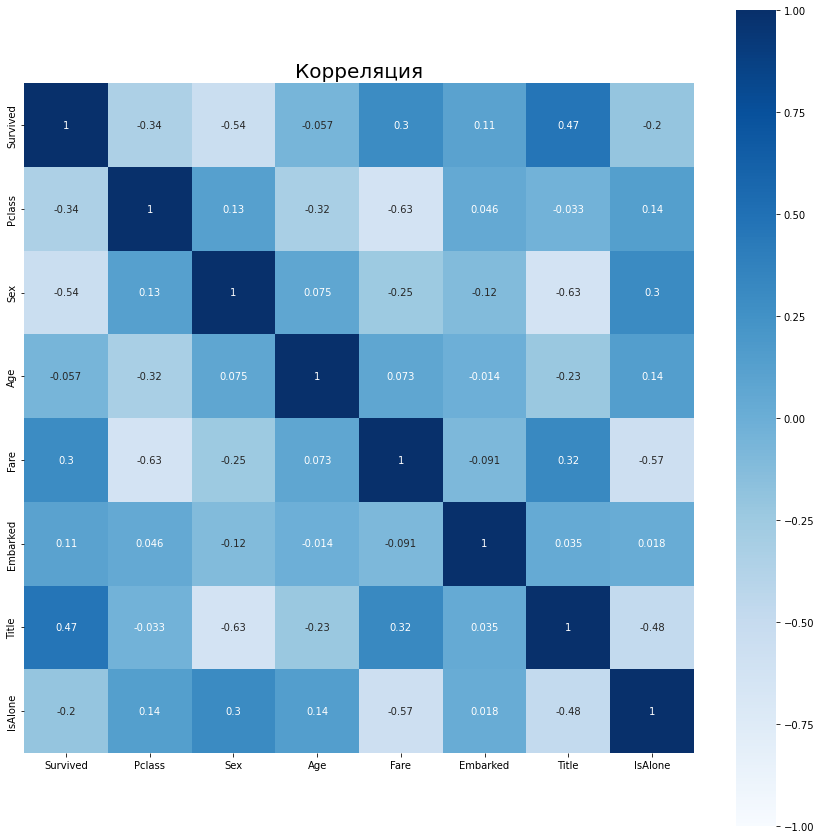

In [39]:
cor_plot(p_df_train)

***Исходя из полученных результатов:***

|Количественная мера тесноты связи|	Качественная характеристика силы связи|
|---------------------------------|---------------------------------------|
|0,1 - 0,3                        | Слабая                                |
|0,3 - 0,5                        | Умеренная                             |
|0,5 - 0,7                        | Заметная                              |
|0,7 - 0,9                        | Высокая                               |
|0,9 - 0,99                       | Весьма высокая                        |

Руководствуясь шкалой Чеддока, замечаем, что у нас есть случаи заметной линейной связи.

## Промежуточный вывод

In [40]:
p_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int32
 1   Pclass    891 non-null    int32
 2   Sex       891 non-null    int32
 3   Age       891 non-null    int32
 4   Fare      891 non-null    int32
 5   Embarked  891 non-null    int32
 6   Title     891 non-null    int32
 7   IsAlone   891 non-null    int64
dtypes: int32(7), int64(1)
memory usage: 31.4 KB


* В итоговую таблицу вошла $891$ запись.
* Данные предобработаны, все необходимые признаки собрали в финальную таблицу.
* Будем придерживаться стратегии по исключению фичей на этапе обучения.

## 6. Обучение моделей


### 6.1 Подготовка train/validation

In [41]:
# enableing the Apache Arrow for converting
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

train_df = spark.createDataFrame(p_df_train)
test_df = spark.createDataFrame(p_df_test)
data_res = {}

In [42]:
print(f'Train: {train_df.columns}\nTest: {test_df.columns}')

Train: ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'IsAlone']
Test: ['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'IsAlone']


In [43]:
info_spark_df(train_df)

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Fare: integer (nullable = true)
 |-- Embarked: integer (nullable = true)
 |-- Title: integer (nullable = true)
 |-- IsAlone: long (nullable = true)

Data size: 891 row(s), 8 column(s)
+--------+------+---+---+----+--------+-----+-------+
|Survived|Pclass|Sex|Age|Fare|Embarked|Title|IsAlone|
+--------+------+---+---+----+--------+-----+-------+
|       0|     0|  0|  0|   0|       0|    0|      0|
+--------+------+---+---+----+--------+-----+-------+

-RECORD 0-----------------------
 summary  | count               
 Survived | 891                 
 Pclass   | 891                 
 Sex      | 891                 
 Age      | 891                 
 Fare     | 891                 
 Embarked | 891                 
 Title    | 891                 
 IsAlone  | 891                 
-RECORD 1-----------------------
 summary  | mean    

Данные успешно подготовлены для обучения модели.

In [44]:
# Выделение векторного столбца
train_df = VectorAssembler(inputCols=['Pclass', 'Sex', 'Age', 'Fare',
                                       'Embarked', 'Title', 'IsAlone'],
                           outputCol='features_vector').transform(train_df)

train_df = train_df.selectExpr('features_vector as features', 'Survived as label')

In [45]:
train_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[3.0,1.0,1.0,0.0,...|    0|
|[1.0,0.0,2.0,3.0,...|    1|
|[3.0,0.0,1.0,1.0,...|    1|
|[1.0,0.0,2.0,3.0,...|    1|
|[3.0,1.0,2.0,1.0,...|    0|
+--------------------+-----+
only showing top 5 rows



Разбиение на train/valid

In [46]:
train, validation = train_df.randomSplit([0.85, 0.15], seed = RND)

print("Тренировочный сет: {}\nВалидационный сет: {}".format(train.shape(), validation.shape()))

Тренировочный сет: (776, 2)
Валидационный сет: (115, 2)


### 6.2 Naive Bayes Classification

In [47]:
nb = NaiveBayes(labelCol='label', featuresCol='features', smoothing=1.0, modelType='gaussian')
nbm = nb.fit(train)

Предсказания

In [48]:
predictions_nb = nbm.transform(validation)
predictions_nb.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,1.0,2.0,3.0,...|    0|[-2.6215655624905...|[0.54439862141613...|       0.0|
|[3.0,0.0,1.0,0.0,...|    1|[-5.7321433787881...|[0.29508494234575...|       1.0|
|[1.0,0.0,3.0,3.0,...|    1|[-10.179133704906...|[0.00122091140135...|       1.0|
|[1.0,1.0,0.0,2.0,...|    0|[-2.3764556611118...|[0.67546991488731...|       0.0|
|[1.0,1.0,0.0,3.0,...|    1|[-2.9068750356101...|[0.64851500085239...|       0.0|
|[2.0,0.0,1.0,2.0,...|    1|[-4.8742287762251...|[0.00893909036249...|       1.0|
|[2.0,1.0,1.0,3.0,...|    0|[0.33284995270025...|[0.89861233338399...|       0.0|
|[3.0,0.0,0.0,1.0,...|    1|[-4.1792479055808...|[0.10771908719546...|       1.0|
|[3.0,0.0,1.0,2.0,...|    0|[-2.5989839613580...|[0.10905597564630...|       1.0|
|[1.0,0.0,1.0,3.

In [49]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

accuracy_NaiveBayes = evaluator.evaluate(predictions_nb)
data_res['NaiveBayes'] = accuracy_NaiveBayes
print(f'Accuracy NaiveBayes: {accuracy_NaiveBayes}')

Accuracy NaiveBayes: 0.8097360350806797


### 6.3 Decision Tree Classification

In [50]:
dt = DecisionTreeClassifier(labelCol='label', featuresCol='features', impurity='gini')
dt.setSeed(RND)
dtm = dt.fit(train)

In [51]:
predictions_dt = dtm.transform(validation)
predictions_dt.show(5)

+--------------------+-----+-------------+--------------------+----------+
|            features|label|rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+----------+
|[1.0,1.0,2.0,3.0,...|    0|  [43.0,16.0]|[0.72881355932203...|       0.0|
|[3.0,0.0,1.0,0.0,...|    1|  [17.0,38.0]|[0.30909090909090...|       1.0|
|[1.0,0.0,3.0,3.0,...|    1|   [2.0,84.0]|[0.02325581395348...|       1.0|
|[1.0,1.0,0.0,2.0,...|    0|  [18.0,19.0]|[0.48648648648648...|       1.0|
|[1.0,1.0,0.0,3.0,...|    1|  [43.0,16.0]|[0.72881355932203...|       0.0|
+--------------------+-----+-------------+--------------------+----------+
only showing top 5 rows



In [52]:
accuracy_DecisionTree = evaluator.evaluate(predictions_dt)
data_res['DecisionTree'] = accuracy_DecisionTree
print(f'Accuracy Decision Tree: {accuracy_DecisionTree}')

Accuracy Decision Tree: 0.7885226901245208


### 6.4 Random Forest Classification

In [53]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features', seed=RND)
rf.setSeed(RND)
rfm = rf.fit(train)

In [54]:
predictions_rm = rfm.transform(validation)
predictions_rm.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,1.0,2.0,3.0,...|    0|[14.7862004168854...|[0.73931002084427...|       0.0|
|[3.0,0.0,1.0,0.0,...|    1|[5.73581841792000...|[0.28679092089600...|       1.0|
|[1.0,0.0,3.0,3.0,...|    1|[1.10280955846341...|[0.05514047792317...|       1.0|
|[1.0,1.0,0.0,2.0,...|    0|[14.1438179675278...|[0.70719089837639...|       0.0|
|[1.0,1.0,0.0,3.0,...|    1|[15.7150850432197...|[0.78575425216098...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [55]:
accuracy_RandomForest = evaluator.evaluate(predictions_rm, {evaluator.metricName: "accuracy"})
data_res['RandomForest'] = accuracy_RandomForest
print(f'Accuracy Random Forest: {accuracy_RandomForest}')

Accuracy Random Forest: 0.8347826086956521


### 6.5 Logistic Regression

In [56]:
lr = LogisticRegression(labelCol='label', featuresCol='features', maxIter=100)
lrm = lr.fit(train)

In [57]:
predictions_lr = lrm.transform(validation)
predictions_lr.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,1.0,2.0,3.0,...|    0|[0.92975194790120...|[0.71702495839013...|       0.0|
|[3.0,0.0,1.0,0.0,...|    1|[-1.0928566063039...|[0.25108074256245...|       1.0|
|[1.0,0.0,3.0,3.0,...|    1|[-2.7144059088373...|[0.06212862914204...|       1.0|
|[1.0,1.0,0.0,2.0,...|    0|[-0.7329641008647...|[0.32454461321223...|       1.0|
|[1.0,1.0,0.0,3.0,...|    1|[-0.2481937930027...|[0.43826811802815...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [58]:
accuracy_LogisticRegression = evaluator.evaluate(predictions_lr, {evaluator.metricName: "accuracy"})
data_res['LogisticRegression'] = accuracy_LogisticRegression
print(f'Accuracy LogisticRegression: {accuracy_LogisticRegression}')

Accuracy LogisticRegression: 0.8347826086956521


### 6.6 Multilayer Perceptron

In [59]:
mlp = MultilayerPerceptronClassifier(labelCol='label',
                                     featuresCol='features',
                                     maxIter=100,
                                     layers=[7, 7, 21, 21, 2],
                                     blockSize=128,
                                     seed=RND)
mlpm = mlp.fit(train)

In [60]:
predictions_mlp = mlpm.transform(validation)
predictions_mlp.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,1.0,2.0,3.0,...|    0|[0.00446681728039...|[0.64617770097621...|       0.0|
|[3.0,0.0,1.0,0.0,...|    1|[-0.6569400637257...|[0.33388880555220...|       1.0|
|[1.0,0.0,3.0,3.0,...|    1|[-2.8952731331261...|[0.00437130994057...|       1.0|
|[1.0,1.0,0.0,2.0,...|    0|[-0.8292155185129...|[0.23698229441500...|       1.0|
|[1.0,1.0,0.0,3.0,...|    1|[0.43855345422251...|[0.79022672136360...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [61]:
accuracy_mpl = evaluator.evaluate(predictions_mlp)
data_res['MultilayerPerceptron'] = accuracy_mpl
print('Accuracy MulticlassClassification: {}'.format(accuracy_mpl))

Accuracy MulticlassClassification: 0.8371894409937888


## Вывод

In [62]:
ind = list(data_res.keys())
col = ['Accuracy']
res_models = list(map(lambda x: x * 100, data_res.values()))

result_df = pd.DataFrame(
    columns = col,
    index = ind
)

for i in range(len(res_models)):
    result_df.iloc[i] = res_models[i]
    
print(result_df)

                       Accuracy
NaiveBayes            80.973604
DecisionTree          78.852269
RandomForest          83.478261
LogisticRegression    83.478261
MultilayerPerceptron  83.718944


Без настройки моделей, `MultilayerPerceptron` и `RandomForest` показали наилучшие результаты.

# Создание итогового файла для отправки в Kaggle 

In [63]:
gender_sub_df

DataFrame[PassengerId: int, Survived: int]

In [64]:
test_df.show(5)

+-----------+------+---+---+----+--------+-----+-------+
|PassengerId|Pclass|Sex|Age|Fare|Embarked|Title|IsAlone|
+-----------+------+---+---+----+--------+-----+-------+
|        892|     3|  1|  2|   0|       2|    1|      1|
|        893|     3|  0|  2|   0|       0|    3|      0|
|        894|     2|  1|  3|   1|       2|    1|      1|
|        895|     3|  1|  1|   1|       0|    1|      1|
|        896|     3|  0|  1|   1|       0|    3|      0|
+-----------+------+---+---+----+--------+-----+-------+
only showing top 5 rows



In [65]:
# Выделение векторного столбца
test_df = VectorAssembler(inputCols=['Pclass', 'Sex', 'Age', 'Fare',
                                       'Embarked', 'Title', 'IsAlone'],
                           outputCol='features_vector').transform(test_df)

test_df = test_df.selectExpr('PassengerId', 'features_vector as features')

In [66]:
predictions_rm = rfm.transform(test_df)
predictions_rm.show(5)

+-----------+--------------------+--------------------+--------------------+----------+
|PassengerId|            features|       rawPrediction|         probability|prediction|
+-----------+--------------------+--------------------+--------------------+----------+
|        892|[3.0,1.0,2.0,0.0,...|[17.4343811281188...|[0.87171905640594...|       0.0|
|        893|(7,[0,2,5],[3.0,2...|[9.30270561170376...|[0.46513528058518...|       1.0|
|        894|[2.0,1.0,3.0,1.0,...|[17.2705306149049...|[0.86352653074524...|       0.0|
|        895|[3.0,1.0,1.0,1.0,...|[17.4054690081459...|[0.87027345040729...|       0.0|
|        896|[3.0,0.0,1.0,1.0,...|[10.3637498537336...|[0.51818749268668...|       0.0|
+-----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [67]:
test_df.show(5)

+-----------+--------------------+
|PassengerId|            features|
+-----------+--------------------+
|        892|[3.0,1.0,2.0,0.0,...|
|        893|(7,[0,2,5],[3.0,2...|
|        894|[2.0,1.0,3.0,1.0,...|
|        895|[3.0,1.0,1.0,1.0,...|
|        896|[3.0,0.0,1.0,1.0,...|
+-----------+--------------------+
only showing top 5 rows



In [68]:
submission = predictions_rm.selectExpr('PassengerId', 'cast(prediction as int) as Survived')
submission = submission.toPandas()

In [69]:
submission.to_csv("gender_submission.csv", index=False)
print("Submission successful")

Submission successful
